# Transfer Learning with Pre-trained Models

## Steps
1. Load and preprocess the dataset.
2. Load a pre-trained model (MobileNetV2).
3. Add a new classification head.
4. Compile and train the model.
5. Evaluate the results.

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

## 1. Load and Preprocess the Dataset

In [12]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

(train_ds, val_ds), ds_info = tfds.load(
    "tf_flowers",
    split=["train[:80%]", "train[80%:]"],
    as_supervised=True,
    with_info=True
)

def format_image(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_dataset = train_ds.map(format_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_ds.map(format_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

2025-06-27 19:50:46.887712: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-06-27 19:50:46.976652: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-06-27 19:50:47.072078: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


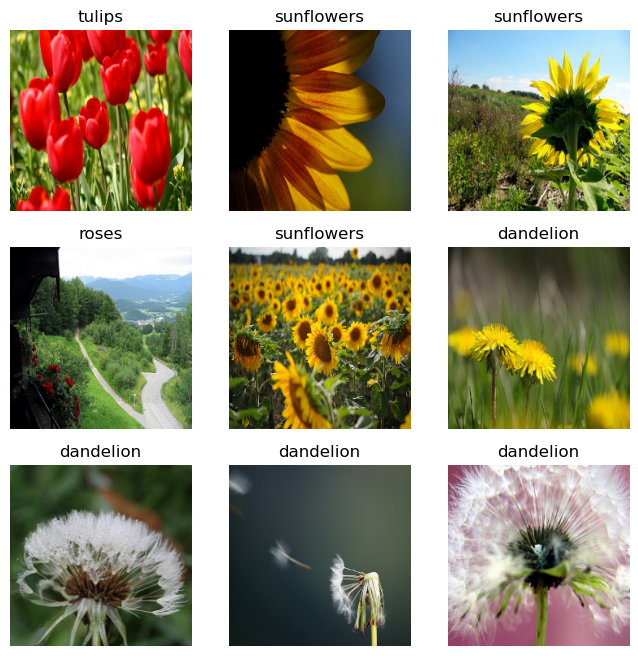

In [ ]:
class_names = ds_info.features["label"].names
plt.figure(figsize=(8, 8))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

## 2. Load a Pre-trained Model

In [6]:
base_model = keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

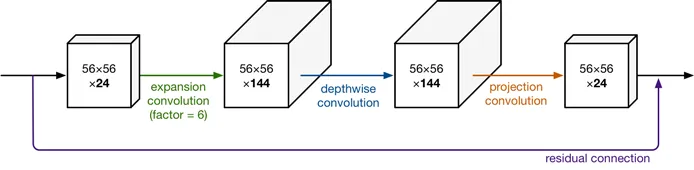

In [7]:
base_model.trainable = False  # Freeze base model

In [11]:
base_model.input_shape, base_model.output_shape

((None, 224, 224, 3), (None, 7, 7, 1280))

In [12]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

## 3. Add a New Classification Head

In [9]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [10]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 4. Compile and Train the Model

In [13]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset
)

Epoch 1/5


2025-06-27 19:54:26.905753: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51380224 exceeds 10% of free system memory.
2025-06-27 19:54:27.081251: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51380224 exceeds 10% of free system memory.
2025-06-27 19:54:27.419390: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154140672 exceeds 10% of free system memory.
2025-06-27 19:54:27.840770: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 156905472 exceeds 10% of free system memory.
2025-06-27 19:54:28.303821: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 38535168 exceeds 10% of free system memory.


92/92 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.5898 - loss: 1.0413 - val_accuracy: 0.8583 - val_loss: 0.4543
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.8695 - loss: 0.4060 - val_accuracy: 0.8787 - val_loss: 0.3852
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.8995 - loss: 0.3203 - val_accuracy: 0.8924 - val_loss: 0.3592
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.9181 - loss: 0.2715 - val_accuracy: 0.8951 - val_loss: 0.3430
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9295 - loss: 0.2363 - val_accuracy: 0.8965 - val_loss: 0.3308


## 5. Evaluate the Model

In [14]:
loss, acc = model.evaluate(val_dataset)

23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 787ms/step - accuracy: 0.9101 - loss: 0.3209


In [15]:
loss, acc

(0.3307928442955017, 0.8964577913284302)

## 6. Plot Training History

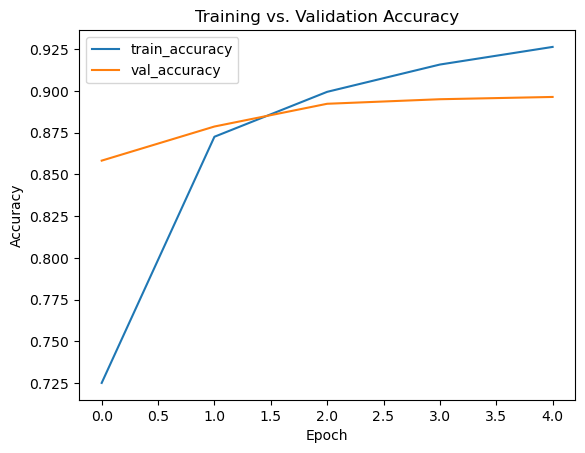

In [16]:
plt.plot(history.history["accuracy"], label="train_accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs. Validation Accuracy")
plt.show()

# 7. Save the Model

In [18]:
model.save("./Data/flower_transfer_model.h5")

In [4]:
loaded_model = keras.models.load_model("./Data/flower_transfer_model.h5")

In [5]:
model = loaded_model

## 7. Fine-tune the Model

In [7]:
base_model.trainable = True

# Freeze all layers except the last few
for layer in base_model.layers[:-20]:
    layer.trainable = False

In [9]:
f"{1e-5:0.5f}"

'0.00001'

In [10]:
model.compile(
    optimizer=keras.optimizers.Adam(0.00001), 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
history_finetune = model.fit(
    train_dataset,
    epochs=3,
    validation_data=val_dataset
)

Epoch 1/3


2025-06-27 20:15:03.677248: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-06-27 20:15:03.717962: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
2025-06-27 20:15:03.807612: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51380224 exceeds 10% of free system memory.
2025-06-27 20:15:03.808852: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
2025-06-27 20:15:03.902877: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
2025-06-27 20:15:03.978198: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51380224 exceeds 10% of free system memory.


92/92 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.9363 - loss: 0.2232 - val_accuracy: 0.9005 - val_loss: 0.3095
Epoch 2/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.9448 - loss: 0.2076 - val_accuracy: 0.9046 - val_loss: 0.3008
Epoch 3/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.9483 - loss: 0.2005 - val_accuracy: 0.9087 - val_loss: 0.2969


In [14]:
loss, acc = model.evaluate(val_dataset)

23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 852ms/step - accuracy: 0.9210 - loss: 0.2883


In [15]:
loss, acc

(0.29691454768180847, 0.9087193608283997)